# Breast Cancer Predictive Modeling

__Import Libraries__

In [1]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')


# Machine learning model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Preprocessing and other utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


__Load the data__

In [0]:
# load the data using Sklearn API
from sklearn.datasets import load_breast_cancer
bunch = load_breast_cancer()

In [3]:
bunch.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

__Custom function definition and Constants__

In [0]:
RANDOM_STATE = 42

def ecdf(arr):
    """
    Calculating Empirical Cumulative Distribution Function

    Parameters
    ----------
    arr : ndarray of shape (n,)
        Array of input

    Returns
    -------
    x, y : ndarray
        x and y are the data points used to plot ECDF 
    """

    n = arr.size
    x = np.sort(arr)
    y = np.arange(1, n + 1) / n

    return x, y


def custom_cross_val(estimator, X, y, cv=5, **kwargs):
    """
    Customize cross_val_score to fit our needs

    Parameters
    ----------
    estimator : scikit-learn estimator

    X : feature matrix

    y : target vector

    Returns
    -------
    scores : cross validation score for 5 different metrics
    """

    metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
    return { metric: cross_val_score(estimator, X, y, cv=cv, scoring=metric, **kwargs) for metric in metrics }


def prettify_scores(scores):
    """
    Print scores nicely

    Parameters
    ----------
    scores : dict
    """

    for key, val in scores.items():
        mean = np.mean(val)
        print(f"{key:10}: {val} ---> Mean : {mean}")


def add_report(dictionary, name, scores, estimator):
    """
    Create reports for each model used. Important keys are 
    `scores` -> list of scores, 
    `best_scores_model` -> contains best score for each metric and its estimator

    Parameters
    ----------
    dictionary : mutable object which will get updated at each model used

    name : the name of model used

    scores : dictionary of scores

    estimator : scikit-learn estimator

    Returns
    -------

    """

    dictionary['scores'][name] = { key: np.mean(val) for key, val in scores.items() }
    dictionary['best_scores_models'] = { 
        key: (np.mean(val), estimator) if np.mean(val) > dictionary['best_scores_models'][key][0] else dictionary['best_scores_models'][key] for key, val in scores.items()
    }


def plot_decision_regions(estimator, X, y, title, width=0.1, figsize=(10, 10), **kwargs):
    """
    
    """

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, width),
                         np.arange(y_min, y_max, width))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.contourf(xx, yy, Z, alpha=0.25, **kwargs)
    sns.scatterplot(X[:, 0], X[:, 1], hue=y, size=y, **kwargs)
    ax.set_title(title)

---

## Preliminary

For the preliminary step, we take a look again to our dataset. We will concatenate feature matrix and target vector into a single dataframe object.

In [5]:
features = pd.DataFrame(bunch.data, columns=bunch.feature_names)
features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
target = pd.Series(np.apply_along_axis(lambda x: bunch.target_names[x], 0, bunch.target), name='target')
target.head()

0    malignant
1    malignant
2    malignant
3    malignant
4    malignant
Name: target, dtype: object

In [7]:
dataset = pd.concat([features, target], axis=1)
dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [8]:
# how many benign and malignant
dataset.target.value_counts(normalize=True)

benign       0.627417
malignant    0.372583
Name: target, dtype: float64

Here, we get over 60% benign data points. So since our dataset is imbalanced, accuracy won't be a good metric this time. We won't use it as the main metric.

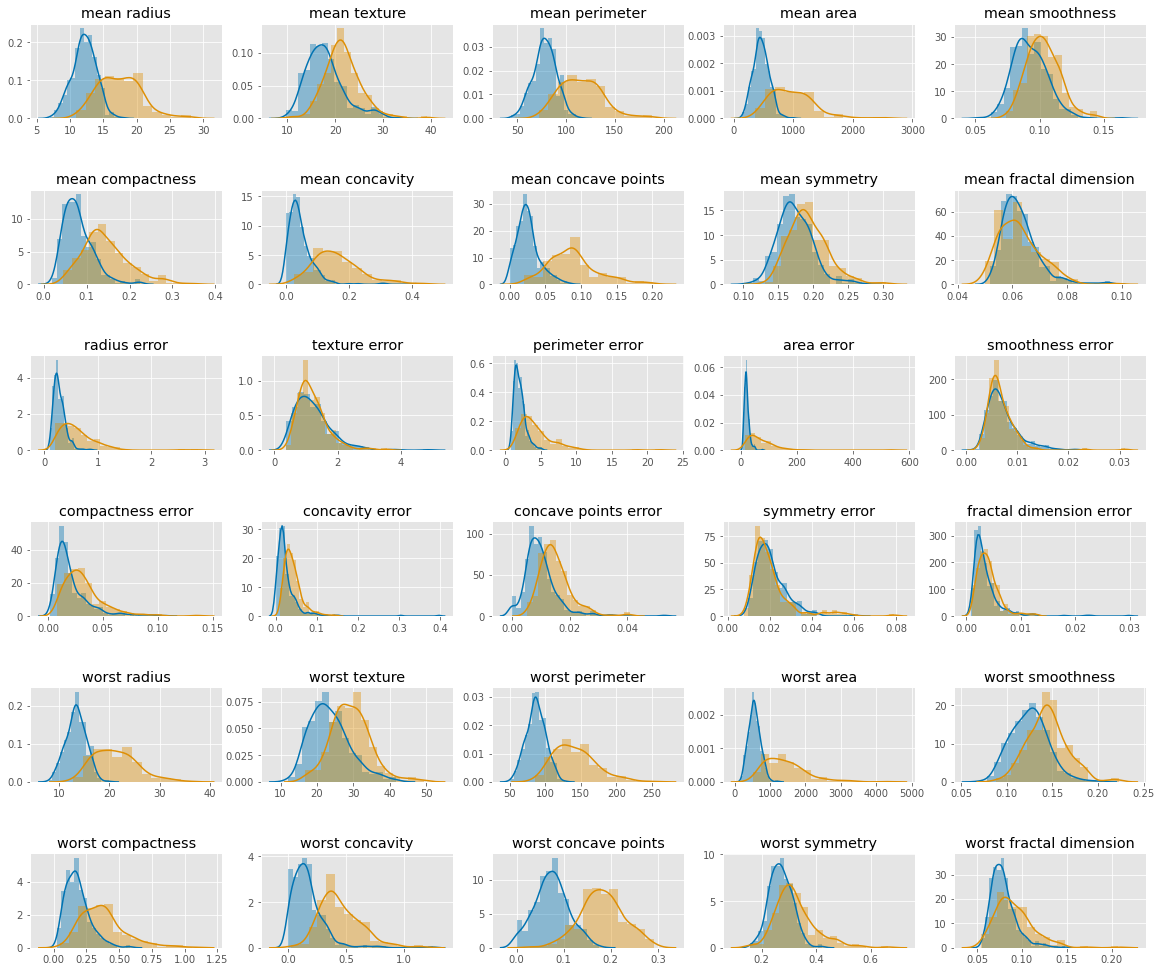

In [9]:
fig, axes = plt.subplots(6, 5, figsize=(20, 17))
fig.subplots_adjust(hspace=0.75)

for (ax, col) in zip(axes.ravel(), dataset.columns[:-1]):
    sns.distplot(dataset.loc[dataset['target'] == 'benign', col], ax=ax)
    sns.distplot(dataset.loc[dataset['target'] == 'malignant', col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')

Based on the plot above, we see that several features could classify the target pretty well independently, such as mean radius and worst concave points. Now, we will look at the empirical cumulative distribution function for each class (benign and malignant) and compare to its normal distribution.

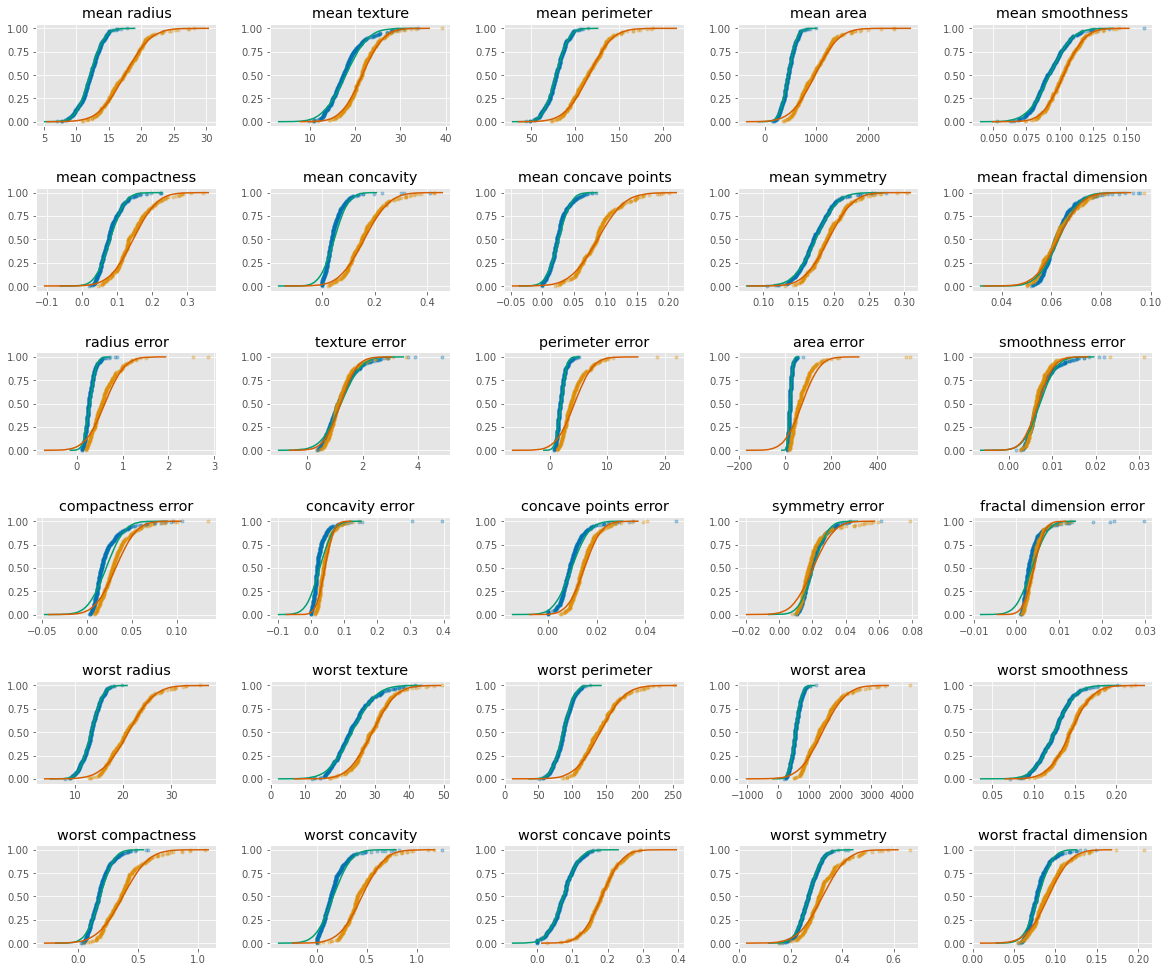

In [10]:
fig, axes = plt.subplots(6, 5, figsize=(20, 17))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for (col, ax) in zip(dataset.columns[:-1], axes.ravel()):
    n = dataset.size
    x_benign, y_benign = ecdf(dataset.loc[dataset['target'] == 'benign', col])
    x_malignant, y_malignant = ecdf(dataset.loc[dataset['target'] == 'malignant', col])
    normal_benign = np.random.normal(x_benign.mean(), x_benign.std(), size=n)
    normal_malignant = np.random.normal(x_malignant.mean(), x_malignant.std(), size=n)
    x_norm_benign, y_norm_benign = ecdf(normal_benign)
    x_norm_malignant, y_norm_malignant = ecdf(normal_malignant)
    ax.plot(x_benign, y_benign, '.', alpha=0.3)
    ax.plot(x_malignant, y_malignant, '.', alpha=0.3)
    ax.plot(x_norm_benign, y_norm_benign)
    ax.plot(x_norm_malignant, y_norm_malignant)
    ax.set_title(col)

Here, we get the empirical cumulative distribution function for each column seperated for each class. Compare to the histrogram before, we see which column that have the same distribution for benign and malignant, which means that it probably won't be a good feature for our predictors. So, if we want to eliminate several features to prevent the curse of dimensionality, we will choose these features. Until then, let's keep it untouch.

What about the correlation between features. How strong each feature related to each other.

In [11]:
correlation = dataset.iloc[:, :-1].corr()
correlation

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Certainly hard to read all of the information above in a huge table. Better to visualize it with seaborn heatmap.

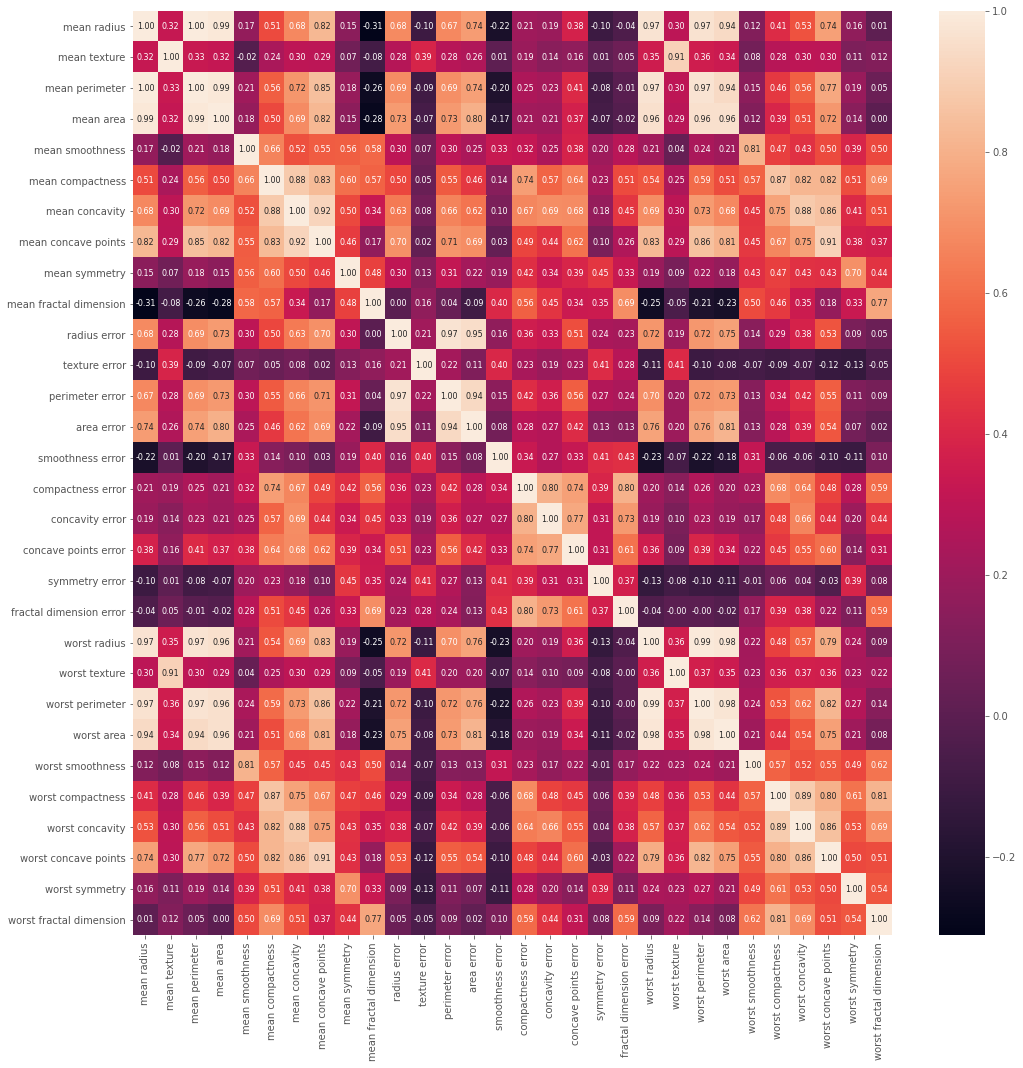

In [12]:
plt.figure(figsize=(17, 17))
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={'fontsize': 8});

Here we saw some features with white color, which means that they have strong correlation. To undestand it better, we will simplify it more by choosing which features with correlation greater than 0.9 or less than -0.9.

In [0]:
strong_pairs = []
for num, (i, row) in enumerate((np.abs(correlation) > 0.9).iterrows()):
    for j, element in row[num:].iteritems():
        if i == j:
            continue
        else:
            if element:
                strong_pairs.append((i, j))

In [14]:
strong_pairs

[('mean radius', 'mean perimeter'),
 ('mean radius', 'mean area'),
 ('mean radius', 'worst radius'),
 ('mean radius', 'worst perimeter'),
 ('mean radius', 'worst area'),
 ('mean texture', 'worst texture'),
 ('mean perimeter', 'mean area'),
 ('mean perimeter', 'worst radius'),
 ('mean perimeter', 'worst perimeter'),
 ('mean perimeter', 'worst area'),
 ('mean area', 'worst radius'),
 ('mean area', 'worst perimeter'),
 ('mean area', 'worst area'),
 ('mean concavity', 'mean concave points'),
 ('mean concave points', 'worst concave points'),
 ('radius error', 'perimeter error'),
 ('radius error', 'area error'),
 ('perimeter error', 'area error'),
 ('worst radius', 'worst perimeter'),
 ('worst radius', 'worst area'),
 ('worst perimeter', 'worst area')]

Above, we have a list of tuples with each tuple contains two features that have strong coefficient of determination. Later, we will see if there any differences for our metrics performance with or without these features.

---

## Base Predictive Modeling

In this section, we will perform predictive modeling without hyperparameter tuning and preprocessing step to let us know how they would be beneficial for our quest to get the best model. But, before we step right into it, let's split the data into training set and validation set. We won't use the validation set up until we get the best model, this set will be used for final check only.

In [0]:
# split the data with stratify argument 
# to make sure our splitted data represent the true full data
X_train, X_valid, y_train, y_valid = train_test_split(bunch.data, bunch.target, test_size=0.2, stratify=bunch.target, random_state=RANDOM_STATE)

In [0]:
# We will populate this dictionary with scores for each step we go through
reports = {
    'scores': {},
    'best_scores_models': {
        'accuracy': (0, None),
        'recall': (0, None),
        'precision': (0, None),
        'f1': (0, None),
        'roc_auc': (0, None),
    }
}

### LogisticRegression

In [17]:
lr = LogisticRegression(random_state=RANDOM_STATE)
logistic_default_cv_scores = custom_cross_val(lr, X_train, y_train)
prettify_scores(logistic_default_cv_scores)

accuracy  : [0.96703297 0.94505495 0.93406593 0.94505495 0.93406593] ---> Mean : 0.945054945054945
recall    : [0.98245614 0.92982456 0.98245614 0.96491228 0.96491228] ---> Mean : 0.9649122807017543
precision : [0.96551724 0.98148148 0.91803279 0.94827586 0.93220339] ---> Mean : 0.9491021523291024
f1        : [0.97391304 0.95495495 0.94915254 0.95652174 0.94827586] ---> Mean : 0.9565636284010994
roc_auc   : [0.99690402 0.98916409 0.97213622 0.99226006 0.98864809] ---> Mean : 0.9878224974200206


In [0]:
add_report(reports, 'LogisticRegression Default', logistic_default_cv_scores, lr)

Even without parameter tuning and preprocessing step the score for all five metrics are awesomely good. Note that because we are dealing with cancer problem (or any illness problem) our focus will be on recall score because we want to minimize false negative. We don't want people with illness uncaught.

### SGDClassifier

In [19]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
sgd_default_scores = custom_cross_val(sgd_clf, X_train, y_train)
prettify_scores(sgd_default_scores)

accuracy  : [0.64835165 0.78021978 0.61538462 0.75824176 0.94505495] ---> Mean : 0.7494505494505495
recall    : [0.43859649 1.         0.38596491 0.61403509 0.96491228] ---> Mean : 0.6807017543859649
precision : [1.         0.74025974 1.         1.         0.94827586] ---> Mean : 0.9377071204657412
f1        : [0.6097561  0.85074627 0.55696203 0.76086957 0.95652174] ---> Mean : 0.7469711391763947
roc_auc   : [0.98864809 0.87151703 0.94891641 0.97832817 0.98245614] ---> Mean : 0.9539731682146544


In [0]:
add_report(reports, 'SGDClassifier Default', sgd_default_scores, sgd_clf)

### GaussianNB

In [21]:
gauss_nb = GaussianNB()
gauss_default_scores = custom_cross_val(gauss_nb, X_train, y_train)
prettify_scores(gauss_default_scores)

accuracy  : [0.93406593 0.94505495 0.93406593 0.93406593 0.93406593] ---> Mean : 0.9362637362637363
recall    : [0.96491228 0.94736842 0.98245614 0.96491228 0.94736842] ---> Mean : 0.9614035087719298
precision : [0.93220339 0.96428571 0.91803279 0.93220339 0.94736842] ---> Mean : 0.9388187403769217
f1        : [0.94827586 0.95575221 0.94915254 0.94827586 0.94736842] ---> Mean : 0.9497649799905649
roc_auc   : [0.98916409 0.99432405 0.98606811 0.9876161  0.98813209] ---> Mean : 0.9890608875129001


In [0]:
add_report(reports, 'GaussianNB Default', gauss_default_scores, gauss_nb)

### KNeighborsClassifier

In [23]:
knn = KNeighborsClassifier()
knn_default_scores = custom_cross_val(knn, X_train, y_train)
prettify_scores(knn_default_scores)

accuracy  : [0.96703297 0.93406593 0.91208791 0.92307692 0.94505495] ---> Mean : 0.9362637362637363
recall    : [0.98245614 0.92982456 0.96491228 0.92982456 0.98245614] ---> Mean : 0.9578947368421051
precision : [0.96551724 0.96363636 0.90163934 0.94642857 0.93333333] ---> Mean : 0.9421109708079747
f1        : [0.97391304 0.94642857 0.93220339 0.9380531  0.95726496] ---> Mean : 0.9495726118694862
roc_auc   : [0.99432405 0.95562436 0.90118679 0.95536636 0.97136223] ---> Mean : 0.9555727554179565


In [0]:
add_report(reports, 'KNeighborsClassifier Default', knn_default_scores, knn)

### LinearSVC

In [25]:
linear_svc = LinearSVC(random_state=RANDOM_STATE)
linear_svc_default_scores = custom_cross_val(linear_svc, X_train, y_train)
prettify_scores(linear_svc_default_scores)

accuracy  : [0.9010989  0.93406593 0.86813187 0.73626374 0.86813187] ---> Mean : 0.8615384615384617
recall    : [1.         0.96491228 1.         0.57894737 0.98245614] ---> Mean : 0.9052631578947368
precision : [0.86363636 0.93220339 0.82608696 1.         0.8358209 ] ---> Mean : 0.8915495211021998
f1        : [0.92682927 0.94827586 0.9047619  0.73333333 0.90322581] ---> Mean : 0.8832852349816998
roc_auc   : [0.98658411 0.97368421 0.9380805  0.98555212 0.98297214] ---> Mean : 0.973374613003096


In [0]:
add_report(reports, 'LinearSVC Default', linear_svc_default_scores, linear_svc)

### SVC

In [27]:
svc = SVC(random_state=RANDOM_STATE)
svc_default_scores = custom_cross_val(svc, X_train, y_train)
prettify_scores(svc_default_scores)

accuracy  : [0.93406593 0.92307692 0.85714286 0.9010989  0.93406593] ---> Mean : 0.9098901098901099
recall    : [0.98245614 1.         0.98245614 0.94736842 0.98245614] ---> Mean : 0.9789473684210526
precision : [0.91803279 0.890625   0.82352941 0.9        0.91803279] ---> Mean : 0.8900439971070394
f1        : [0.94915254 0.94214876 0.896      0.92307692 0.94915254] ---> Mean : 0.931906153630653
roc_auc   : [0.98503612 0.98864809 0.93240454 0.9747162  0.97884417] ---> Mean : 0.9719298245614034


In [0]:
add_report(reports, 'SVC Default', svc_default_scores, svc)

### DecisionTreeClassifier

In [29]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_default_scores = custom_cross_val(dt, X_train, y_train)
prettify_scores(dt_default_scores)

accuracy  : [0.91208791 0.9010989  0.9010989  0.89010989 0.94505495] ---> Mean : 0.9098901098901099
recall    : [0.9122807  0.89473684 0.94736842 0.92982456 0.96491228] ---> Mean : 0.9298245614035088
precision : [0.94545455 0.94444444 0.9        0.89830508 0.94827586] ---> Mean : 0.9272959873427435
f1        : [0.92857143 0.91891892 0.92307692 0.9137931  0.95652174] ---> Mean : 0.9281764226291962
roc_auc   : [0.9120227  0.90325077 0.88544892 0.87667699 0.93833849] ---> Mean : 0.9031475748194013


In [0]:
add_report(reports, 'SVC Default', svc_default_scores, svc)

### RandomForestClassifier

In [31]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest_default_scores  = custom_cross_val(forest, X_train, y_train)
prettify_scores(forest_default_scores)

accuracy  : [0.96703297 0.98901099 0.92307692 0.93406593 0.95604396] ---> Mean : 0.953846153846154
recall    : [0.98245614 1.         0.96491228 0.94736842 0.94736842] ---> Mean : 0.968421052631579
precision : [0.96551724 0.98275862 0.91666667 0.94736842 0.98181818] ---> Mean : 0.9588258263212891
f1        : [0.97391304 0.99130435 0.94017094 0.94736842 0.96428571] ---> Mean : 0.9634084933627266
roc_auc   : [0.98839009 0.999484   0.9631063  0.99019608 0.99638803] ---> Mean : 0.9875128998968007


In [0]:
add_report(reports, 'RandomForestClassifier Default', forest_default_scores, forest)

### GradientBoostingClassifier

In [33]:
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbc_default_scores = custom_cross_val(gbc, X_train, y_train)
prettify_scores(gbc_default_scores)

accuracy  : [0.96703297 0.96703297 0.94505495 0.94505495 0.96703297] ---> Mean : 0.9582417582417582
recall    : [0.96491228 0.96491228 0.98245614 0.96491228 0.96491228] ---> Mean : 0.968421052631579
precision : [0.98214286 0.98214286 0.93333333 0.94827586 0.98214286] ---> Mean : 0.965607553366174
f1        : [0.97345133 0.97345133 0.95726496 0.95652174 0.97345133] ---> Mean : 0.9668281357392553
roc_auc   : [0.99380805 0.99742002 0.95381837 0.99484004 0.99793602] ---> Mean : 0.987564499484004


In [0]:
add_report(reports, 'GradientBoostingClassifier Default', gbc_default_scores, gbc)

### Base Prediction Report

In [35]:
reports['best_scores_models']

{'accuracy': (0.9582417582417582,
  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                             learning_rate=0.1, loss='deviance', max_depth=3,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=100,
                             n_iter_no_change=None, presort='deprecated',
                             random_state=42, subsample=1.0, tol=0.0001,
                             validation_fraction=0.1, verbose=0,
                             warm_start=False)),
 'f1': (0.9668281357392553,
  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                             learning_rate=0.1, loss='deviance', max_depth=3,
                             max_features=None, max_leaf_nodes

Above, we get the result of performing base predictive modeling. The best recall score so far achieved by SVC (default hyperparameter) with score 97%. 

---

## Visualize the higher dimension.

Before we proceed to feature engineering and hyperparameter tuning, let's see how our data get visualized in 2d.

### Principal Component Analysis

In [0]:
# scaling the X_train before feed it into PCA
pipe_pca = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=2, random_state=RANDOM_STATE))])

In [0]:
X_train_pca = pipe_pca.fit_transform(X_train)

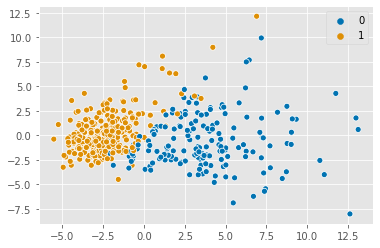

In [38]:
sns.scatterplot(X_train_pca[:, 0], X_train_pca[:, 1], hue=y_train);

### t-SNE

In [0]:
pipe_tsne = Pipeline([('scaler', StandardScaler()),
                      ('tsne', TSNE(n_components=2, random_state=RANDOM_STATE))])

In [0]:
X_train_tsne = pipe_tsne.fit_transform(X_train)

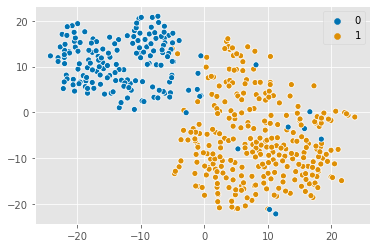

In [41]:
sns.scatterplot(X_train_tsne[:, 0], X_train_tsne[:, 1], hue=y_train);